In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.metrics as metrics
import keras as ks
import scanpy as sc

In [3]:
test_anndata = sc.read_h5ad("../../Data/granulomas_final_test_anndata.h5ad")
test_anndata_hvg = test_anndata[:, test_anndata.var['highly_variable'] ].copy()

In [4]:
test_anndata_hvg

AnnData object with n_obs × n_vars = 5521 × 3475
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts', 'type', 'sample', 'batch_type', 'batch', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'n_counts', 'size_factors', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.6', 'leiden_0.8', 'leiden_1.0', 'leiden_1.4', 'leiden_1.7', 'leiden_2.0', 'leiden_2.5', 'leiden_3.0', 'leiden_3.5', 'leiden_4.0', 'leiden_4.5', 'hclust', 'kmeans', 'my_clust_1', 'immune', 'mesothelial', 'stromal', 'endothelial', 'epithelial', 'muscle', 'Immune', 'Myeloid', 'Lymphoid', 'Mesenchyme', 'Mesothelial', 'Stromal', 'SMC', 'Endothelial', 'Blood vessels', 'LEC', 'Epithelial', 'Ciliated', 'Secretory', 'single_cell_types'
    v

In [5]:
test_anndata_hvg.obs['single_cell_types']

GACCAATAGTGTACTC_sc69_1         AT2-t2
CACACCTGTCAGATAA_sc69_1             DC
CTCGAAAAGGATGTAT_sc72_1            AT1
CACACCTTCTGCTTGC_sc70_1           CAP2
CAAGAAAAGAAGGCCT_sc69_1           M-t2
                              ...     
CAACTAGGTGCGGTAA_sc69_1            pDC
ACATGGTTCCTGTAGA_sc70_1            Th1
CTCGGGAGTTCAGACT_sc72_1            Th1
CGTCCATGTACATGTC_sc69_1    Mesothelial
CATCCACAGGGTTTCT_sc72_1           M-t1
Name: single_cell_types, Length: 5521, dtype: category
Categories (30, object): ['AF', 'AM', 'AT1', 'AT2', ..., 'Treg', 'VEC', 'iMon', 'pDC']

In [6]:
finest_level = "single_cell_types"
cell_types = sorted(test_anndata_hvg.obs[finest_level].unique())
int_mapping = {groups: i for i, groups in enumerate(cell_types)}
test_anndata_hvg.obs["cell_integers"] = test_anndata_hvg.obs[finest_level].map(int_mapping)

In [7]:
test_anndata_hvg.obs["cell_integers"]

GACCAATAGTGTACTC_sc69_1     5
CACACCTGTCAGATAA_sc69_1    11
CTCGAAAAGGATGTAT_sc72_1     2
CACACCTTCTGCTTGC_sc70_1     9
CAAGAAAAGAAGGCCT_sc69_1    16
                           ..
CAACTAGGTGCGGTAA_sc69_1    29
ACATGGTTCCTGTAGA_sc70_1    24
CTCGGGAGTTCAGACT_sc72_1    24
CGTCCATGTACATGTC_sc69_1    17
CATCCACAGGGTTTCT_sc72_1    15
Name: cell_integers, Length: 5521, dtype: category
Categories (30, int64): [0, 1, 2, 3, ..., 26, 27, 28, 29]

In [8]:
test_features = test_anndata_hvg.X
test_labels = test_anndata_hvg.obs['cell_integers'].values

In [9]:
model = ks.models.load_model(f"../../Models/granulomas_final_hvg_flat_jax_v1.keras", custom_objects={'LeakyReLU': ks.layers.LeakyReLU}, compile=False)
print(model.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_33          │ (None, 3475)           │        13,900 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 370)            │     1,286,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 370)            │         1,480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 370)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 30)             │        11,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,312,630 (5.01 MB)

 Trainable params: 1,304,940 (4.98 MB)

 Non-trainable params: 7,690 (30.04 KB)

None


In [10]:
logits = model.predict(test_features)
max_indices = np.argmax(logits, axis=1)

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


In [ ]:
test_features = np.load('../../Arrays/test_features_hvg_subset.npy')
test_labels = np.load('../../Arrays/test_labels_hvg_subset.npy')

In [ ]:
model = keras.models.load_model("../../Models/granulomas30_hvg_subset_jax_v1.keras", custom_objects={'LeakyReLU': ks.layers.LeakyReLU}) 

In [ ]:
model.summary()

In [ ]:
prediction = model.predict(test_features)

In [ ]:
max_indices = np.argmax(prediction, axis=1)

In [11]:
def overall_metrics(y_true, y_pred, average='weighted'):

    results = {
        'accuracy': metrics.accuracy_score(y_true, y_pred),
        'precision': metrics.precision_score(y_true, y_pred, average=average, zero_division=0),
        'recall': metrics.recall_score(y_true, y_pred, average=average),
        'f1_score': metrics.f1_score(y_true, y_pred, average=average),
    }

    return results

In [12]:
def class_metrics(y_true, y_pred):
    return metrics.classification_report(y_true, y_pred, zero_division=0)

In [13]:
def create_confusion_matrix(y_true, y_pred):
    return metrics.confusion_matrix(y_true, y_pred)

In [14]:
def plot_confusion_matrix(y_true, y_pred):
    confusion_matrix = create_confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sb.heatmap(confusion_matrix, annot=True, fmt="d", cmap='Reds', cbar=True, xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
def roc_auc_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, multi_class='ovr')

In [ ]:
def roc_auc_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, multi_class='ovo')

In [ ]:
def average_precision(y_true, y_score): 
    return metrics.average_precision_score(y_true, y_score, average='weighted')

In [15]:
def balanced_accuracy(y_true, y_pred):
    return metrics.balanced_accuracy_score(y_true, y_pred)

In [16]:
overall_metrics(test_labels, max_indices)

{'accuracy': 0.9346132946929904,
 'precision': 0.9374686962273053,
 'recall': 0.9346132946929904,
 'f1_score': 0.9348484489043348}

In [17]:
print(class_metrics(test_labels, max_indices))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       0.80      0.97      0.88       199
           2       0.98      0.94      0.96        68
           3       0.99      0.95      0.97       364
           4       0.95      0.96      0.95       174
           5       0.83      0.99      0.90        76
           6       0.98      1.00      0.99       414
           7       0.86      0.68      0.76        28
           8       0.94      0.98      0.96       148
           9       1.00      0.95      0.98        43
          10       0.99      1.00      0.99        80
          11       0.97      1.00      0.98       155
          12       1.00      1.00      1.00        11
          13       0.81      0.92      0.86        71
          14       0.82      0.75      0.78       233
          15       0.94      0.91      0.93      1139
          16       0.80      0.80      0.80       219
          17       1.00    

In [18]:
int_mapping

{'AF': 0,
 'AM': 1,
 'AT1': 2,
 'AT2': 3,
 'AT2-t1': 4,
 'AT2-t2': 5,
 'B1': 6,
 'B2': 7,
 'CAP1': 8,
 'CAP2': 9,
 'Ciliated': 10,
 'DC': 11,
 'LEC': 12,
 'M-C1q': 13,
 'M-lc': 14,
 'M-t1': 15,
 'M-t2': 16,
 'Mesothelial': 17,
 'N1': 18,
 'N2': 19,
 'NK': 20,
 'Pericyte': 21,
 'Secretory': 22,
 'Tex': 23,
 'Th1': 24,
 'Tnaive': 25,
 'Treg': 26,
 'VEC': 27,
 'iMon': 28,
 'pDC': 29}

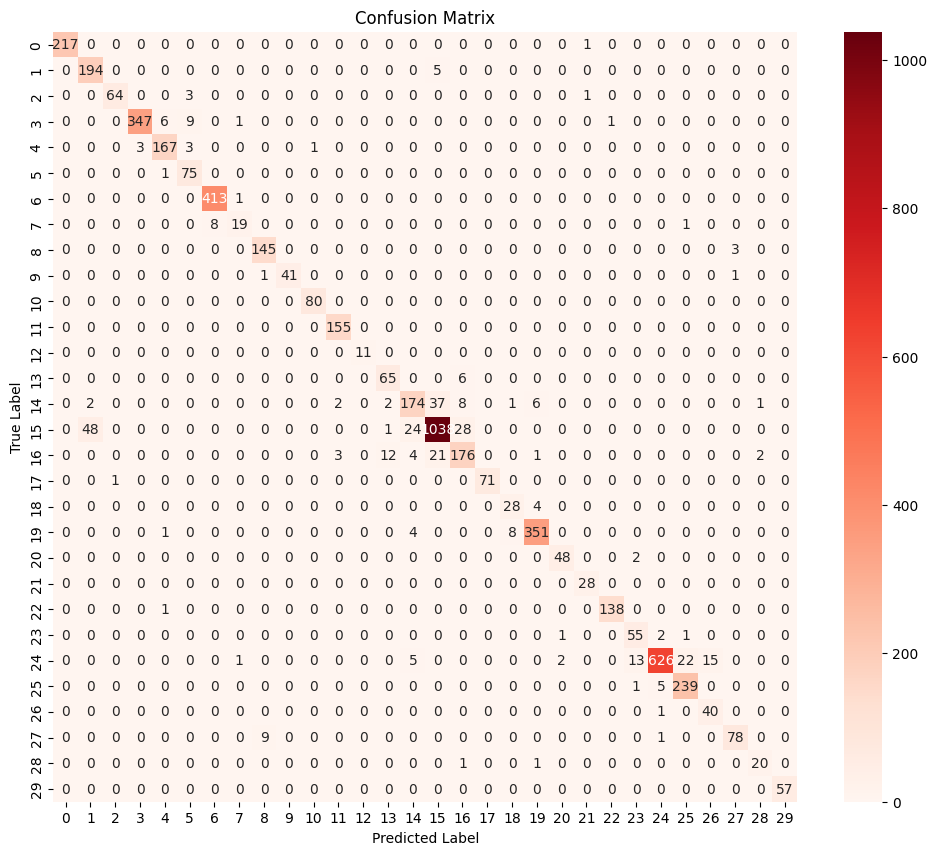

In [19]:
plot_confusion_matrix(test_labels, max_indices)

In [ ]:
# roc_auc_ovr(test_labels, prediction)

In [ ]:
# roc_auc_ovo(test_labels, prediction)

In [ ]:
# average_precision(test_labels, prediction)

In [20]:
balanced_accuracy(test_labels, max_indices)

0.9390061534015117